Import Needed Libraries

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat
import networkx as nx
import numpy as np

In [6]:
base_path = 'C:/Users/SYYAD/Documents/MSAI/AI in Healthcare/MIMIC-VISUALIZATION/MIMIC3-Files/'

First Visualization: Event Count by Hour

Understand which hours of the day have the most recorded events in the ICU.

Visualization: Bar Chart

Tables : DATETIMEEVENTS

In [4]:
# Load the DATE TIME EVENT CSV file
file_path = base_path + "DATETIMEEVENTS.csv"  
datetimeevents = pd.read_csv(file_path, low_memory=False)

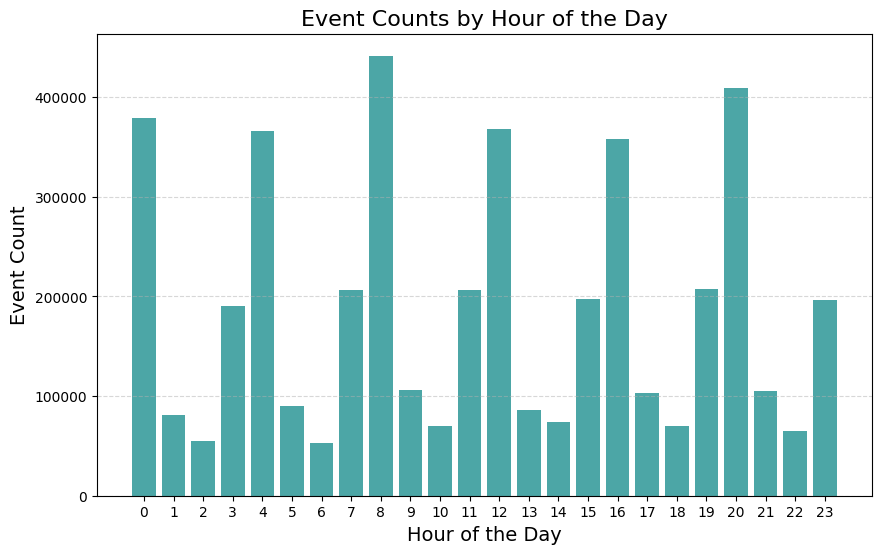

In [5]:
# Convert CHARTTIME to datetime format
datetimeevents['CHARTTIME'] = pd.to_datetime(datetimeevents['CHARTTIME'], errors='coerce')

# Drop rows with invalid or missing CHARTTIME
datetimeevents = datetimeevents.dropna(subset=['CHARTTIME'])

# Extract the hour from CHARTTIME
datetimeevents['hour'] = datetimeevents['CHARTTIME'].dt.hour

# Count events per hour
event_counts = datetimeevents['hour'].value_counts().sort_index()

# Plot a bar chart of event counts by hour
plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values, color='teal', alpha=0.7)
plt.title("Event Counts by Hour of the Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Event Count", fontsize=14)
plt.xticks(range(0, 24))  # Ensure all 24 hours are represented
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Second Visualization: Fluid Input vs. Mortality

Compare the total fluid input during ICU stays with mortality outcomes.

Visualization: Box Plot

Tables: INPUTEVENTS_MV + ADMISSIONS

In [7]:
file_path = base_path + "INPUTEVENTS_MV.csv" 
inputevents_mv = pd.read_csv(file_path, parse_dates=['STARTTIME', 'ENDTIME'])

file_path = base_path + "ADMISSIONS.csv" 
admissions = pd.read_csv(file_path, parse_dates=['ADMITTIME', 'DISCHTIME', 'DEATHTIME'])

In [8]:
# Aggregate fluid input per hospital admission (HADM_ID)
fluid_input = (
    inputevents_mv.groupby('HADM_ID')
    .agg({'AMOUNT': 'sum'})
    .reset_index()
    .rename(columns={'AMOUNT': 'TOTAL_FLUID_INPUT'})
)

# Merge with ADMISSIONS table to get mortality data
admissions['MORTALITY'] = admissions['DEATHTIME'].notnull()
fluid_input = fluid_input.merge(admissions[['HADM_ID', 'MORTALITY']], on='HADM_ID', how='inner')

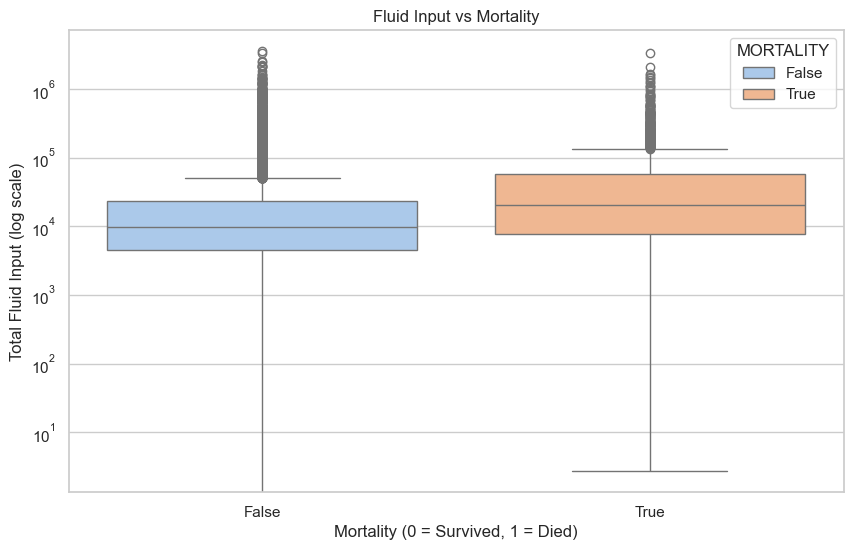

In [12]:
# Visualize fluid input vs. mortality
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=fluid_input, x='MORTALITY', y='TOTAL_FLUID_INPUT', hue='MORTALITY', palette='pastel', dodge=False)
plt.yscale('log')  # Log scale for better visualization of outliers
plt.xlabel('Mortality (0 = Survived, 1 = Died)')
plt.ylabel('Total Fluid Input (log scale)')
plt.title('Fluid Input vs Mortality')
plt.show()

Third Visualization: Lab Test(Glucose) Trends by ICU Type

Track how specific lab values (e.g., glucose) vary over time in different ICU types (e.g., medical ICU, surgical ICU).

Visualization : Heap Map

Tables: LABEVENTS + ICUSTAYS

In [15]:
# Load LABEVENTS and ICUSTAYS data
labevents = pd.read_csv(base_path + "LABEVENTS.csv")
icustays = pd.read_csv(base_path + "ICUSTAYS.csv")

In [16]:
# Filter for glucose tests (ITEMID for glucose is typically 50809 in MIMIC-III)
glucose_itemid = 50809
labevents_glucose = labevents[labevents['ITEMID'] == glucose_itemid]

# Select required columns for merging
labevents_glucose = labevents_glucose[['HADM_ID', 'VALUENUM']]  # Use HADM_ID here
icustays = icustays[['HADM_ID', 'FIRST_CAREUNIT']]  # Use HADM_ID here

# Merge LABEVENTS with ICUSTAYS to get ICU type
merged_data = pd.merge(labevents_glucose, icustays, on='HADM_ID', how='inner')

# Group by ICU type and calculate mean glucose value
grouped_data = (
    merged_data.groupby('FIRST_CAREUNIT')
    .agg({'VALUENUM': 'mean'})
    .reset_index()
)

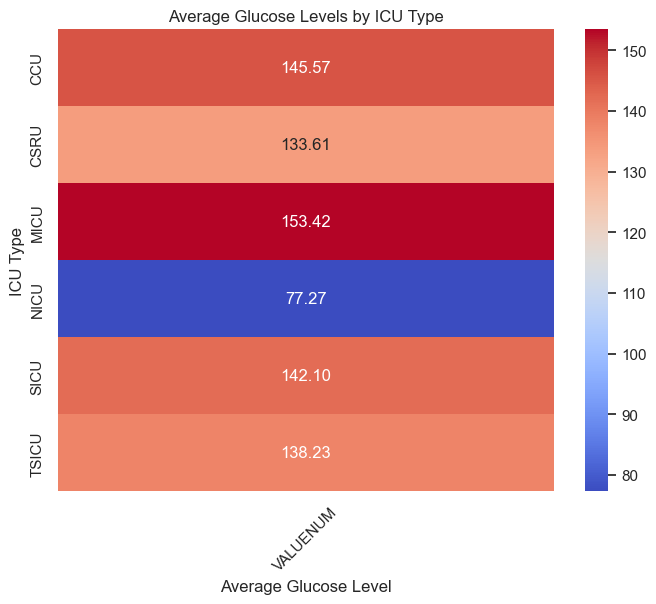

In [17]:
# Plot heatmap using grouped data
plt.figure(figsize=(8, 6))
sns.heatmap(
    grouped_data.set_index('FIRST_CAREUNIT'),
    annot=True,
    cmap="coolwarm",
    cbar=True,
    fmt=".2f"
)
plt.title("Average Glucose Levels by ICU Type")
plt.ylabel("ICU Type")
plt.xlabel("Average Glucose Level")
plt.xticks(rotation=45)
plt.show()

Fourth Visualization: ICU Transfers and Readmissions

Explore patterns in patient transfers between ICUs and readmission rates

Visualization: Sankey diagram

Tables: TRANSFERS + ADMISSIONS

In [18]:
import plotly.graph_objects as go

In [19]:
transfers = pd.read_csv(base_path + "TRANSFERS.csv") 

In [20]:
# Preprocessing
# Merge TRANSFERS with ADMISSIONS to get unique patients and their ICUs
merged_data = pd.merge(
    transfers,
    admissions[['HADM_ID', 'SUBJECT_ID']],
    on='HADM_ID',
    how='inner'
)

In [21]:
# Prepare source (PREV_CAREUNIT) and target (CURR_CAREUNIT) columns
source_target_data = transfers.groupby(['PREV_CAREUNIT', 'CURR_CAREUNIT']).size().reset_index(name='count')

# Remove rows where PREV_CAREUNIT is null (e.g., first ICU admissions)
source_target_data = source_target_data.dropna(subset=['PREV_CAREUNIT'])

# Create a mapping of ICU units to numeric indices
all_units = pd.concat([source_target_data['PREV_CAREUNIT'], source_target_data['CURR_CAREUNIT']]).unique()
unit_to_index = {unit: idx for idx, unit in enumerate(all_units)}

# Map ICU units to numeric indices for Sankey
source_target_data['source'] = source_target_data['PREV_CAREUNIT'].map(unit_to_index)
source_target_data['target'] = source_target_data['CURR_CAREUNIT'].map(unit_to_index)

In [22]:
# Create Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(unit_to_index.keys()),  # ICU care units
        color="blue"
    ),
    link=dict(
        source=source_target_data['source'],  # Numeric index of previous units
        target=source_target_data['target'],  # Numeric index of current units
        value=source_target_data['count']  # Counts of transfers
    )
)])

# Update layout
fig.update_layout(
    title_text="ICU Transfers (Sankey Diagram)",
    font_size=12
)

fig.show()

Fifth Visualization: Procedures by Age Group

Compare the frequency of common procedures across different age groups.

Visualization: Grouped bar chart

Tables: PROCEDURES_ICD + PATIENTS + ADMISSION

In [47]:
PROCEDURES_ICD = pd.read_csv(base_path + "PROCEDURES_ICD.csv", low_memory=False)  
PATIENTS = pd.read_csv(base_path + "PATIENTS.csv", low_memory=False)  
ADMISSION = pd.read_csv(base_path + "ADMISSIONS.csv", low_memory=False)

In [64]:
# Merge PROCEDURES_ICD with PATIENTS on SUBJECT_ID and then merge with ADMISSION on SUBJECT_ID
merged_data = pd.merge(PROCEDURES_ICD, PATIENTS, on='SUBJECT_ID', how='inner')
sec_merged_data = pd.merge(merged_data, ADMISSION, on='SUBJECT_ID', how='inner')

In [54]:
sec_merged_data['DOB'] = pd.to_datetime(sec_merged_data['DOB'], errors='coerce')
sec_merged_data['ADMITTIME'] = pd.to_datetime(sec_merged_data['ADMITTIME'], errors='coerce')

In [ ]:
sec_merged_data['AGE_AT_ADMISSION'] = sec_merged_data['ADMITTIME'].dt.year - sec_merged_data['DOB'].dt.year

In [ ]:
sec_merged_data['ADJUSTED_AGE'] = sec_merged_data['AGE_AT_ADMISSION'].apply(lambda x: '89+' if x > 89 else x)

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_6868\788149199.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



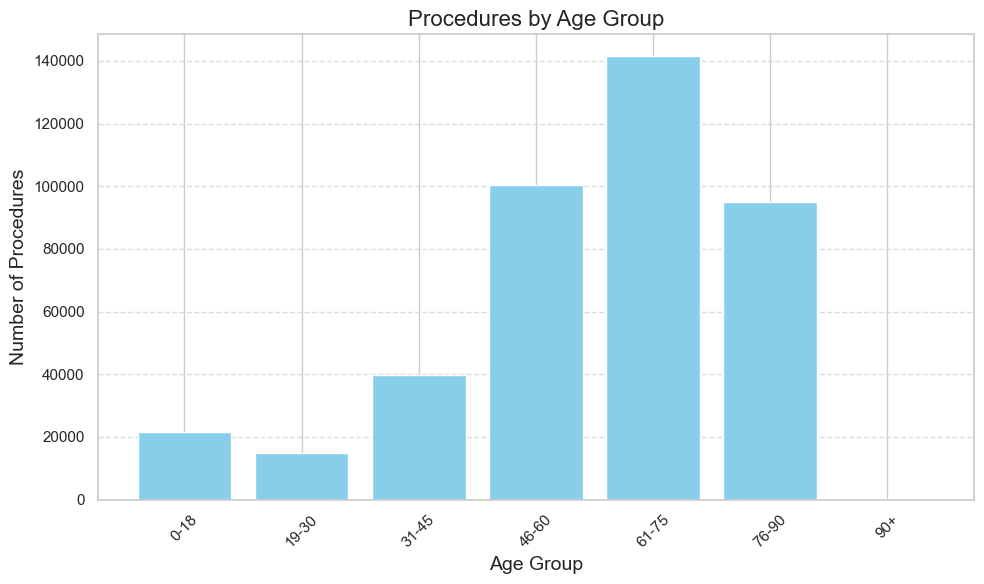

In [63]:
# Convert ADJUSTED_AGE to numeric, setting errors='coerce' to handle non-numeric values
sec_merged_data['ADJUSTED_AGE'] = pd.to_numeric(sec_merged_data['ADJUSTED_AGE'], errors='coerce')

# Define age groups
bins = [0, 18, 30, 45, 60, 75, 90, np.inf]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '90+']
sec_merged_data['AGE_GROUP'] = pd.cut(sec_merged_data['ADJUSTED_AGE'], bins=bins, labels=labels, right=False)

# Count procedures by age group
procedure_counts = sec_merged_data.groupby('AGE_GROUP')['ICD9_CODE'].count().reset_index()
procedure_counts = procedure_counts.rename(columns={'ICD9_CODE': 'PROCEDURE_COUNT'})

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(procedure_counts['AGE_GROUP'], procedure_counts['PROCEDURE_COUNT'], color='skyblue')
plt.title('Procedures by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Procedures', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()